The software library ``chaospy`` is meant to be used together with the standard library ``numpy``. In addition we will use ``matplotlib`` to plot results.

In [1]:
import chaospy
import numpy
import matplotlib.pyplot as plt

First we start by defining a model function. Wee in general assume is a wrapper for some larger numerical solver, but for the sake of demonstration, let the model be defined analytically as an exponential function. the important part is that solver is deterministic, its shape is defined by the input. Bot input and output is here assumed to be ``numpy``.

In [2]:
def foo(coordinates, parameters):
    """Over simplistic model function."""
    return parameters[0]*numpy.e**(-parameters[1]*coordinates)

Here ``coord`` are temporal coordinates in one dimensions, and ``parameters`` consists of two model parameters that defines the shape of the solution. We furthermore assume that the ``coordinates`` defined on the interval ``(0, 1)``:

In [3]:
coordinates = numpy.linspace(0, 10, 1000)

And assume that ``parameters`` is unknown, but can be described through a bivariate uniform probability distribution:

In [4]:
marginal1 = chaospy.Uniform(1, 2)
marginal2 = chaospy.Uniform(0.1, 0.2)
distribution = chaospy.J(marginal1, marginal2)

To visualize the variability in the model we generate 50 samples from the distribution which we then use to evaluate the model:

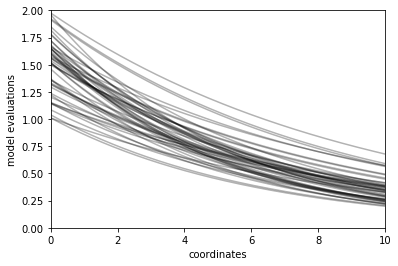

In [5]:
plt.xlabel("coordinates")
plt.ylabel("model evaluations")
plt.axis([0, 10, 0, 2])
for parameters in distribution.sample(50).T:
    plt.plot(coordinates, foo(coordinates, parameters), "k-", alpha=0.3)

Our goal is therefore to describe the bahavior of ``foo`` with only having a blackbox evaluation function of ``foo`` available. We will here take a look at three different approaches: Monte Carlo Integration (MCI), Point Collocation method (PCM) and Pseudo-Spectral Projection (PSP).

# Monte Carlo Integration
Performing Monte Carlo requires that one can create samples, from the input distribution.
In ``chaospy`` such samples can be generated each distributions ``sample`` methods, as noted above.
To generate samples from pseudo-random samples like e.g. the Hammersley sequence, a flag in ``sample`` can be issued to indicate the type of sample.

array([[1.125     , 1.625     , 1.375     , 1.875     , 1.0625    ],
       [0.14444444, 0.17777778, 0.12222222, 0.15555556, 0.18888889]])

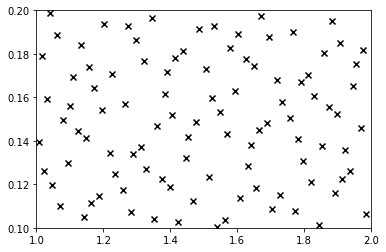

In [6]:
number_of_samples = 1000
samples = distribution.sample(number_of_samples, rule="halton")

plt.axis([1, 2, 0.1, 0.2])
plt.scatter(*samples[:, :100], marker="x", color="k")

samples[:, :5]

These samples can be used to generate model evaluations:

In [7]:
evaluations = numpy.array([foo(coordinates, sample) for sample in samples.T])
evaluations.shape

(1000, 1000)

These samples can then be used to do analysis using tools from the standard ``numpy`` library:

(array([1.49914453, 1.49689747, 1.49465391, 1.49241383, 1.49017723]),
 array([0.28856203, 0.28813074, 0.28770078, 0.28727216, 0.28684487]))

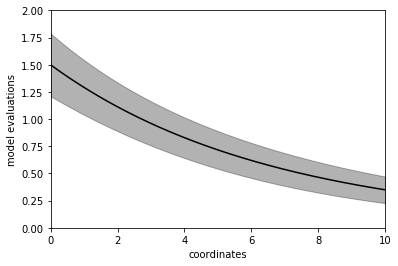

In [8]:
expected = np.mean(evaluations, axis=0)
std = np.std(evaluations, axis=0)

plt.xlabel("coordinates")
plt.ylabel("model evaluations")
plt.axis([0, 10, 0, 2])
plt.fill_between(coordinates, expected-std, expected+std, alpha=0.3, color="k")
plt.plot(coordinates, expected, "k-")

expected[:5], std[:5]

# Point Collocation Method

The simpler of the two non-intrusive polynomial chaos expansion methods is the point collocation method.
It builds upon the idea of fitting a polynomial to the samples generated in the Monte Carlo simulation step.

For example, to generate a polynomial expansion and fit it to the 1000 samples generated, the following steps can be employed.
First an expansion to be fitted must be generated:

In [9]:
polynomial_order = 4
polynomial_expansion = cp.orth_ttr(polynomial_order, distribution)
polynomial_expansion[:6].round(4)

polynomial([1.0, -0.15+q1, -1.5+q0, 0.0217-0.3*q1+q1**2,
            0.225-1.5*q1-0.15*q0+q0*q1, 2.1667-3.0*q0+q0**2])

Here we choose the polynomial expansion to be orthogonal, though for point collocation method, this is not a strict requirement.

In [10]:
outer_product = chaospy.outer(polynomial_expansion[:4], polynomial_expansion[:4])
chaospy.E(outer_product, distribution)

array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 8.33333333e-04, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 8.33333333e-02, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.55555556e-07]])

With the samples, evaluations and polynomial expansion available, an polynomial approximation can be created using a regression method:

In [11]:
evaluations = numpy.array([foo(coordinates, sample) for sample in samples.T])
foo_approx = chaospy.fit_regression(polynomial_expansion, samples, evaluations)
foo_approx[:5].round(3)

polynomial([q0, q0-0.01*q0*q1, q0-0.02*q0*q1, q0-0.03*q0*q1,
            q0-0.04*q0*q1+0.001*q0*q1**2])

With the approximation available, analysis can be done:

(array([1.5       , 1.4977495 , 1.4955025 , 1.493259  , 1.49101899]),
 array([0.28867513, 0.28824236, 0.28781094, 0.28738085, 0.2869521 ]))

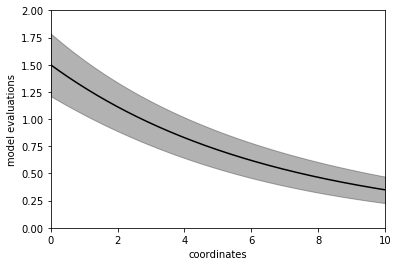

In [12]:
expected = chaospy.E(foo_approx, distribution)
std = chaospy.Std(foo_approx, distribution)

plt.xlabel("coordinates")
plt.ylabel("model evaluations")
plt.axis([0, 10, 0, 2])
plt.fill_between(coordinates, expected-std, expected+std, alpha=0.3, color="k")
plt.plot(coordinates, expected, "k-")

expected[:5], std[:5]

# Pseudo-spectral Projection method

The second non-intrusive polynomial chaos expansion method involves calculating the Fourier coefficients using numerical integration techniques.
Unless the integration technique is Monte Carlo integration (in which the method defaults back to point collocation), the samples from the Monte Carlo simulation can not be reused.
Instead new samples from a fitting integration scheme must be employed.

Like Point Collocation Method above, we need a polynomial expansion to work with:

In [13]:
polynomial_order = 4
polynomial_expansion = chaospy.orth_ttr(polynomial_order, distribution)
polynomial_expansion[:6].round(4)

polynomial([1.0, -0.15+q1, -1.5+q0, 0.0217-0.3*q1+q1**2,
            0.225-1.5*q1-0.15*q0+q0*q1, 2.1667-3.0*q0+q0**2])

In addition we need absissas and weights from an quadrature scheme:

(array([[1.        , 1.        , 1.        , 1.        ],
        [0.1       , 0.10380602, 0.11464466, 0.13086583]]),
 array([6.29881582e-05, 5.80232735e-04, 1.10859158e-03, 1.43538833e-03]))

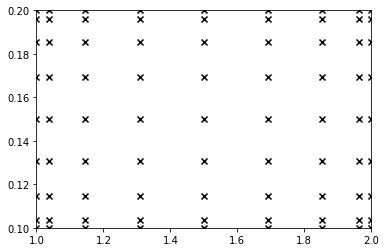

In [14]:
quadrature_order = 8
abscissas, weights = chaospy.generate_quadrature(quadrature_order, distribution, rule="clenshaw_curtis")

plt.axis([1, 2, 0.1, 0.2])
plt.scatter(*abscissas, color="k", marker="x")
abscissas[:, :4], weights[:4]

These can then be used to create an polynomial approximation as follows:

In [15]:
evaluations = [foo(coordinates, abscissa) for abscissa in abscissas.T]
foo_approx = chaospy.fit_quadrature(polynomial_expansion, abscissas, weights, evaluations)
foo_approx[:5].round(3)

polynomial([q0, q0-0.01*q0*q1, q0-0.02*q0*q1, q0-0.03*q0*q1,
            q0-0.04*q0*q1+0.001*q0*q1**2])

The expected value and variance is calculated as before:

(array([1.5       , 1.4977495 , 1.4955025 , 1.493259  , 1.49101899]),
 array([0.28867513, 0.28824236, 0.28781094, 0.28738085, 0.2869521 ]))

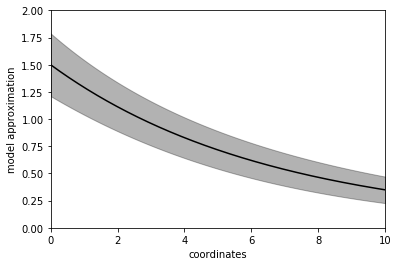

In [16]:
expected = chaospy.E(foo_approx, distribution)
std = chaospy.Std(foo_approx, distribution)

plt.xlabel("coordinates")
plt.ylabel("model approximation")
plt.axis([0, 10, 0, 2])
plt.fill_between(coordinates, expected-std, expected+std, alpha=0.3, color="k")
plt.plot(coordinates, expected, "k-")

expected[:5], std[:5]